In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import os
import cv2
import numpy as np
from easydict import EasyDict as edict
import yaml

import matplotlib
import matplotlib.pyplot as plt
import pylab

plt.rcParams['figure.figsize'] = (5,5)

from data_aug import Normalize_Img, Anti_Normalize_Img

In [2]:
def padding_img(img_ori, size=224, color=128):
    height = img_ori.shape[0]
    width = img_ori.shape[1]
    img = np.zeros((max(height, width), max(height, width), 3)) + color
    
    if (height > width):
        padding = int((height-width)/2)
        img[:, padding:padding+width, :] = img_ori
    else:
        padding = int((width-height)/2)
        img[padding:padding+height, :, :] = img_ori
        
    img = np.uint8(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    return np.array(img, dtype=np.float32)

def resize_padding(image, dstshape, padValue=0):
    height, width, _ = image.shape
    ratio = float(width)/height # ratio = (width:height)
    dst_width = int(min(dstshape[1]*ratio, dstshape[0]))
    dst_height = int(min(dstshape[0]/ratio, dstshape[1]))
    origin = [int((dstshape[1] - dst_height)/2), int((dstshape[0] - dst_width)/2)]
    if len(image.shape)==3:
        image_resize = cv2.resize(image, (dst_width, dst_height))
        newimage = np.zeros(shape = (dstshape[1], dstshape[0], image.shape[2]), dtype = np.uint8) + padValue
        newimage[origin[0]:origin[0]+dst_height, origin[1]:origin[1]+dst_width, :] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    else:
        image_resize = cv2.resize(image, (dst_width, dst_height),  interpolation = cv2.INTER_NEAREST)
        newimage = np.zeros(shape = (dstshape[1], dstshape[0]), dtype = np.uint8)
        newimage[origin[0]:origin[0]+height, origin[1]:origin[1]+width] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    return newimage, bbx

def generate_input(exp_args, inputs, prior=None):
    inputs_norm = Normalize_Img(inputs, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    
    if exp_args.video == True:
        if prior is None:
            prior = np.zeros((exp_args.input_height, exp_args.input_width, 1))
            inputs_norm = np.c_[inputs_norm, prior]
        else:
            prior = prior.reshape(exp_args.input_height, exp_args.input_width, 1)
            inputs_norm = np.c_[inputs_norm, prior]
       
    inputs = np.transpose(inputs_norm, (2, 0, 1))
    return np.array(inputs, dtype=np.float32)

def pred_single(model, exp_args, img_ori, prior=None):
    model.eval()
    softmax = nn.Softmax(dim=1)
    
    in_shape = img_ori.shape
    img, bbx = resize_padding(img_ori, [exp_args.input_height, exp_args.input_width], padValue=exp_args.padding_color)
    
    in_ = generate_input(exp_args, img, prior)
    in_ = in_[np.newaxis, :, :, :]
    
    if exp_args.addEdge == True:
        output_mask, output_edge = model(Variable(torch.from_numpy(in_)).cuda())
    else:
        output_mask = model(Variable(torch.from_numpy(in_)).cuda())
    prob = softmax(output_mask)
    pred = prob.data.cpu().numpy()
    
    predimg = pred[0].transpose((1,2,0))[:,:,1]
    out = predimg[bbx[1]:bbx[3], bbx[0]:bbx[2]]
    out = cv2.resize(out, (in_shape[1], in_shape[0]))
    return out, predimg

In [3]:
# # EG1800: config_path = 'config_EG1800.yaml'
config_path = 'config_EG1800.yaml'

# # EG1800: config_path = 'config_EG1800_2000Epoch.yaml'
# config_path = 'config_EG1800_2000Epoch.yaml'

# EG1800_face_detection: config_path = 'config_EG1800_face_detection.yaml'
# config_path = 'config_EG1800_face_detection.yaml'

# mattinghuman: config_path = 'config_mattinghuman.yaml'
# config_path = 'config_mattinghuman.yaml'

# EasyPortraint_eyes: config_path = 'config_EasyPortrait_eyes.yaml'
# config_path = 'config_EasyPortrait_eyes.yaml'

# EasyPortraint_teeth: config_path = 'config_EasyPortrait_teeth.yaml'
# config_path = 'config_EasyPortrait_teeth.yaml'

with open(config_path,'rb') as f:
    cont = f.read()
cf = yaml.safe_load(cont)

print ('finish load config file ...')

finish load config file ...


In [4]:
exp_args = edict()    
exp_args.istrain = False
exp_args.task = cf['task']
exp_args.datasetlist = cf['datasetlist'] # ['EG1800', ATR', 'MscocoBackground', 'supervisely_face_easy']

exp_args.model_root = cf['model_root'] 
exp_args.data_root = cf['data_root']
exp_args.file_root = cf['file_root']

# the height of input images, default=224
exp_args.input_height = cf['input_height']
# the width of input images, default=224
exp_args.input_width = cf['input_width']

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = cf['video']
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = cf['prior_prob']

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = cf['addEdge']
# whether to add consistency constraint loss, default=False
exp_args.stability = cf['stability']

# input normalization parameters
exp_args.padding_color = cf['padding_color']
exp_args.img_scale = cf['img_scale']
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = cf['img_mean']
# BGR order, image val, default=[0.017, 0.017, 0.017]
exp_args.img_val = cf['img_val'] 

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = cf['useUpsample'] 
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = cf['useDeconvGroup'] 

exp_args.faceDetection = cf['faceDetection']
exp_args.offSet = cf['offSet']

# print ('===========> loading model <===========')
import portraitnet
netmodel_video = portraitnet.MobileNetV2(n_class=2, 
                                      useUpsample=exp_args.useUpsample, 
                                      useDeconvGroup=exp_args.useDeconvGroup, 
                                      addEdge=exp_args.addEdge, 
                                      channelRatio=1.0, 
                                      minChannel=16, 
                                      weightInit=True,
                                      video=exp_args.video).cuda()


bestModelFile = os.path.join(exp_args.model_root, 'model_best.pth.tar')
if os.path.isfile(bestModelFile):
    checkpoint_video = torch.load(bestModelFile)
    netmodel_video.load_state_dict(checkpoint_video['state_dict'])
    print ("minLoss: ", checkpoint_video['minLoss'], checkpoint_video['epoch'])
    print("=> loaded checkpoint '{}' (epoch {})".format(bestModelFile, checkpoint_video['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(bestModelFile))

c:\Users\PANDA\anaconda3\envs\AI_torch_CUDA112\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


minLoss:  0.05383258894940168 184
=> loaded checkpoint 'D:/Code/MDS_6004/My_model/myexp/eg1800/model_best.pth.tar' (epoch 184)


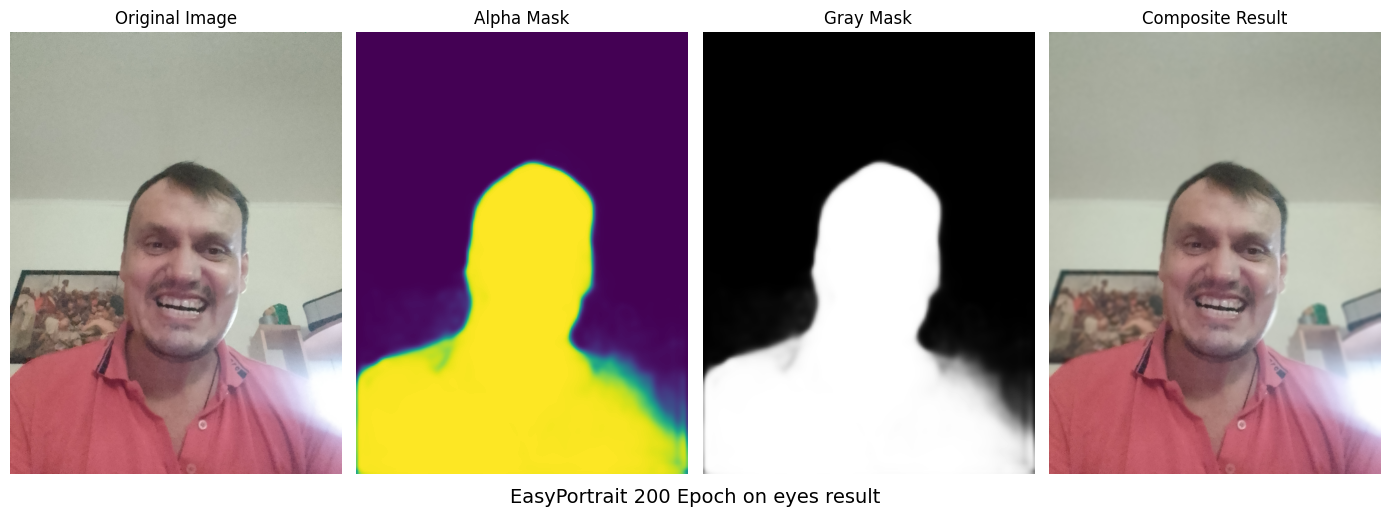

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 读取原始图片
# img_ori = cv2.imread("D:/ML_dataset/EG1800/Images/00457.png")
# img_ori = cv2.imread("D:/ML_dataset/woman-2806675_1920.jpg") # non center face
img_ori = cv2.imread("d:/ML_dataset/new_archive/images/test/cc297b7a-5da4-448a-85f5-f9964273f108.jpg") # with teeth

prior = None
height, width, _ = img_ori.shape

# 背景模糊
background = img_ori.copy()
background = cv2.blur(background, (17, 17))

# 获取 alpha mask 和预测
alphargb, pred = pred_single(netmodel_video, exp_args, img_ori, prior)

# 将 alphargb 转为 BGR 格式用于结果叠加
alphargb_bgr = cv2.cvtColor(alphargb, cv2.COLOR_GRAY2BGR)
result = np.uint8(img_ori * alphargb_bgr + background * (1 - alphargb_bgr))

# 创建 1x4 的图像布局
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

# 显示原图
axes[0].imshow(img_ori[:, :, ::-1] / 255)  # BGR to RGB
axes[0].set_title('Original Image')
axes[0].axis('off')

# 显示 alpha mask (灰度图)
axes[1].imshow(alphargb)
axes[1].set_title('Alpha Mask')
axes[1].axis('off')

# 显示背景模糊图
axes[2].imshow(alphargb, cmap='gray')
axes[2].set_title('Gray Mask')
axes[2].axis('off')

# 显示最终叠加结果
axes[3].imshow(result[:, :, ::-1] / 255)  # BGR to RGB
axes[3].set_title('Composite Result')
axes[3].axis('off')

fig.text(0.5, 0, 'EasyPortrait 200 Epoch on eyes result', 
         ha='center', fontsize=14)

# 调整布局并展示
plt.tight_layout()
# plt.savefig('plot_result/EasyPortrait_eyes.png', dpi=150, bbox_inches='tight')
plt.show()
